# PokerML

In [1]:
# Disable some console warnings
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import numpy as np

from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.utils import to_categorical

Make sure that you have Vivado suite in your environment.

In [3]:
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

## Configuration

In [4]:
DATA_DIR = "data"

MODELS_DIR = 'models/'
DATA_NPY_DIR = DATA_DIR + '/npy/Suits_npy/'

IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
TEST_SIZE = 0.2
NUM_CLASSES = 4

QKERAS_TRAIN = True ## I did not debug yet the issue with the QKeras saved model

## Load data

In [5]:
X_train_val = np.load(DATA_NPY_DIR + 'X_train_val.npy')
X_test = np.load(DATA_NPY_DIR + 'X_test.npy')
y_train_val = np.load(DATA_NPY_DIR + 'y_train_val.npy')
y_test = np.load(DATA_NPY_DIR + 'y_test.npy')
classes = np.load(DATA_NPY_DIR + 'classes.npy', allow_pickle=True)

In [6]:
print('Train and validation set:', X_train_val.shape[0])
print('Test set:                ', X_test.shape[0])
print('Classes:                 ', classes.shape[0])

Train and validation set: 7987
Test set:                 1997
Classes:                  4


## Train QKeras model

In [7]:
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import Activation
from qkeras import QDense, QActivation, QConv2D
from qkeras.quantizers import quantized_bits, quantized_relu

# # ENABLE THIS IF YOU USE PRUNING
# from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
# from tensorflow_model_optimization.sparsity.keras import strip_pruning
# import tensorflow_model_optimization as tfmot

import pickle

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

In [8]:
CHECKPOINT_FILENAME = MODELS_DIR + 'qkeras/suits_model.h5'

model = Sequential()

model.add(QConv2D(4,
                 kernel_size=(3, 3),
                 input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3),
                 kernel_quantizer=quantized_bits(6, 0, alpha=1),
                 bias_quantizer=quantized_bits(6, 0, alpha=1),
                 kernel_initializer='lecun_uniform',
                 kernel_regularizer=l1(0.0001),
                 name='conv1'))

model.add(QActivation(activation=quantized_relu(6),
                      name='relu1'))

model.add(MaxPooling2D(pool_size=(2, 2),
                       name='maxpool1'))

model.add(QConv2D(4,
                 kernel_size=(3, 3),
                 kernel_quantizer=quantized_bits(6, 0, alpha=1),
                 bias_quantizer=quantized_bits(6, 0, alpha=1),
                 kernel_initializer='lecun_uniform',
                 kernel_regularizer=l1(0.0001),
                 name='conv2'))

model.add(QActivation(activation=quantized_relu(6),
                      name='relu2'))

model.add(MaxPooling2D(pool_size=(2, 2),
                       name='maxpool2'))

model.add(Flatten(name='flatten'))

# model.add(QDense(32,
#                  kernel_quantizer=quantized_bits(6, 0, alpha=1),
#                  bias_quantizer=quantized_bits(6, 0, alpha=1),
#                  kernel_initializer='lecun_uniform',
#                  kernel_regularizer=l1(0.0001),
#                  name='dense1'))

# model.add(QActivation(activation=quantized_relu(6),
#                       name='relu3'))

model.add(QDense(NUM_CLASSES,
                 kernel_quantizer=quantized_bits(6, 0, alpha=1),
                 bias_quantizer=quantized_bits(6, 0, alpha=1),
                 kernel_initializer='lecun_uniform',
                 kernel_regularizer=l1(0.0001),
                 activation='softmax',
                 name='output'))


model.summary()
# # adding pruning 
# pruning_params = {
#     'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
#         initial_sparsity=0.50,
#         final_sparsity=0.80,
#         begin_step=200,
#         end_step=1000)
# }
# model = prune.prune_low_magnitude(model, **pruning_params)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (QConv2D)             (None, 62, 62, 4)         112       
                                                                 
 relu1 (QActivation)         (None, 62, 62, 4)         0         
                                                                 
 maxpool1 (MaxPooling2D)     (None, 31, 31, 4)         0         
                                                                 
 conv2 (QConv2D)             (None, 29, 29, 4)         148       
                                                                 
 relu2 (QActivation)         (None, 29, 29, 4)         0         
                                                     

In [9]:
if QKERAS_TRAIN:
    from qkeras.utils import model_save_quantized_weights

    # Using learning rate with exponential decay
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        0.001,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True
    )
    adam = Adam(learning_rate=lr_schedule)
    
    #adam = Adam(learning_rate=0.001)

    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])

    # A few other callbacks. These should not give warnings on deprecated features.
    callbacks = [
            ModelCheckpoint(
                CHECKPOINT_FILENAME,
                monitor='val_loss',
                verbose=0,
                save_best_only=True,
                save_weights_only=False,
                save_freq='epoch')
       #,
       #pruning_callbacks.UpdatePruningStep()
       #,#ReduceLROnPlateau(patience=75, min_delta=1**-6), 
    ]

    history = model.fit(
        X_train_val,
        y_train_val,
        batch_size=128,
        epochs=30,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks
    )
    
# # Strip the model of pruning information
#     model = strip_pruning(model)
#    model.save(CHECKPOINT_FILENAME)

    # Use this instead if you use the callbacks
    history_file = CHECKPOINT_FILENAME.replace('.h5', '-history.pkl')
    with open(history_file, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

    print(f'Saving history to: {history_file}')
    print(f'Saved checkpoint to: {CHECKPOINT_FILENAME}')


else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects
    co = {}
    _add_supported_quantized_objects(co)
    model = load_model(CHECKPOINT_FILENAME, custom_objects=co, compile=False)

Epoch 1/30
47/47 [==============================] - 7s 114ms/step - loss: 1.3694 - accuracy: 0.3172 - val_loss: 1.2707 - val_accuracy: 0.4632
Epoch 2/30
47/47 [==============================] - 4s 94ms/step - loss: 1.1423 - accuracy: 0.5479 - val_loss: 1.0256 - val_accuracy: 0.6375
Epoch 3/30
47/47 [==============================] - 4s 96ms/step - loss: 0.9110 - accuracy: 0.6715 - val_loss: 0.8336 - val_accuracy: 0.7076
Epoch 4/30
47/47 [==============================] - 4s 92ms/step - loss: 0.7551 - accuracy: 0.7457 - val_loss: 0.7158 - val_accuracy: 0.7611
Epoch 5/30
47/47 [==============================] - 4s 91ms/step - loss: 0.6562 - accuracy: 0.7907 - val_loss: 0.6393 - val_accuracy: 0.7802
Epoch 6/30
47/47 [==============================] - 4s 93ms/step - loss: 0.5892 - accuracy: 0.8152 - val_loss: 0.5739 - val_accuracy: 0.8262
Epoch 7/30
47/47 [==============================] - 4s 93ms/step - loss: 0.5253 - accuracy: 0.8426 - val_loss: 0.5238 - val_accuracy: 0.8488
Epoch 8/30
4

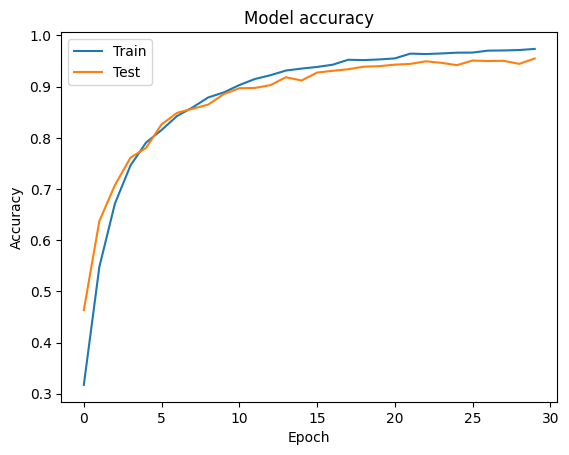

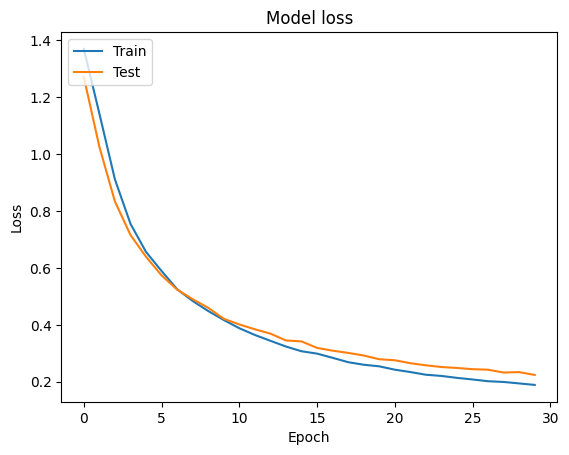

In [10]:
if QKERAS_TRAIN:
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Test')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

In [11]:
y_qkeras = model.predict(np.ascontiguousarray(X_test))

print("QKeras accuracy: {:.6f}%".format(100.*accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))

63/63 [==============================] - 1s 14ms/step
QKeras accuracy: 95.693540%


Pre trained model sul have accuracy = 98.030708%

## QKeras to hls4ml (Quantization Aware Training)

In [12]:
import hls4ml
import plotting

# First, the baseline model
hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')

# Set the precision and reuse factor for the full model
hls_config['Model']['Precision'] = 'ap_fixed<32,16>'
hls_config['Model']['ReuseFactor'] = 256
hls_config['Model']['Strategy'] = 'Resource'


# Create an entry for each layer, here you can for instance change the strategy for a layer to 'resource'
# or increase the reuse factor individually for large layers.
for Layer in hls_config['LayerName'].keys():
    hls_config['LayerName'][Layer]['Strategy'] = 'Resource'
    hls_config['LayerName'][Layer]['ReuseFactor'] = 512
    hls_config['LayerName'][Layer]['Trace'] = True

# hls_config['LayerName']['output']['Strategy'] = 'Stable'
plotting.print_dict(hls_config)

cfg = hls4ml.converters.create_config(backend='VivadoAccelerator')
cfg['IOType'] = 'io_stream'  # Must set this if using CNNs!
cfg['HLSConfig'] = hls_config
cfg['KerasModel'] = model
cfg['OutputDir'] = 'projects/qat_hls4ml_prj_Suits'
#cfg['XilinxPart'] = 'xcu250-figd2104-2L-e'

hls_model = hls4ml.converters.keras_to_hls(cfg)

Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: InputLayer, input shapes: [[None, 64, 64, 3]], output shape: [None, 64, 64, 3]
Layer name: conv1, layer type: QConv2D, input shapes: [[None, 64, 64, 3]], output shape: [None, 62, 62, 4]
Layer name: relu1, layer type: Activation, input shapes: [[None, 62, 62, 4]], output shape: [None, 62, 62, 4]
Layer name: maxpool1, layer type: MaxPooling2D, input shapes: [[None, 62, 62, 4]], output shape: [None, 31, 31, 4]
Layer name: conv2, layer type: QConv2D, input shapes: [[None, 31, 31, 4]], output shape: [None, 29, 29, 4]
Layer name: relu2, layer type: Activation, input shapes: [[None, 29, 29, 4]], output shape: [None, 29, 29, 4]
Layer name: maxpool2, layer type: MaxPooling2D, input shapes: [[None, 29, 29, 4]], output shape: [None, 14, 14, 4]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 14, 14, 4]], output shape: [None, 784]
Layer name: output, layer type: QDense, input shapes: [[None, 784]], output shape: 

/home/esp2024/rht2122/miniconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


In [13]:
hls_model.compile()

Writing HLS project
Done


In [14]:
# IF PREDICTION TAKE TOO MUCH PLEASE
# REDUCE THE NUMBER OF INPUTS
print(X_test.shape)
print(X_test[:10].shape)

(1997, 64, 64, 3)
(10, 64, 64, 3)


In [15]:
y_qkeras = model.predict(np.ascontiguousarray(X_test))
y_hls = hls_model.predict(np.ascontiguousarray(X_test))

63/63 [==============================] - 1s 14ms/step


In [16]:
%matplotlib inline
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

#print("Accuracy baseline:  {:.6f}%".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("Accuracy quantized: {:.6f}%".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml:    {:.6f}%".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

Accuracy quantized: 0.956935%
Accuracy hls4ml:    0.955433%


```
With pretrained model you should expect:
Accuracy quantized: 0.980307%
Accuracy hls4ml:    0.979973%
```

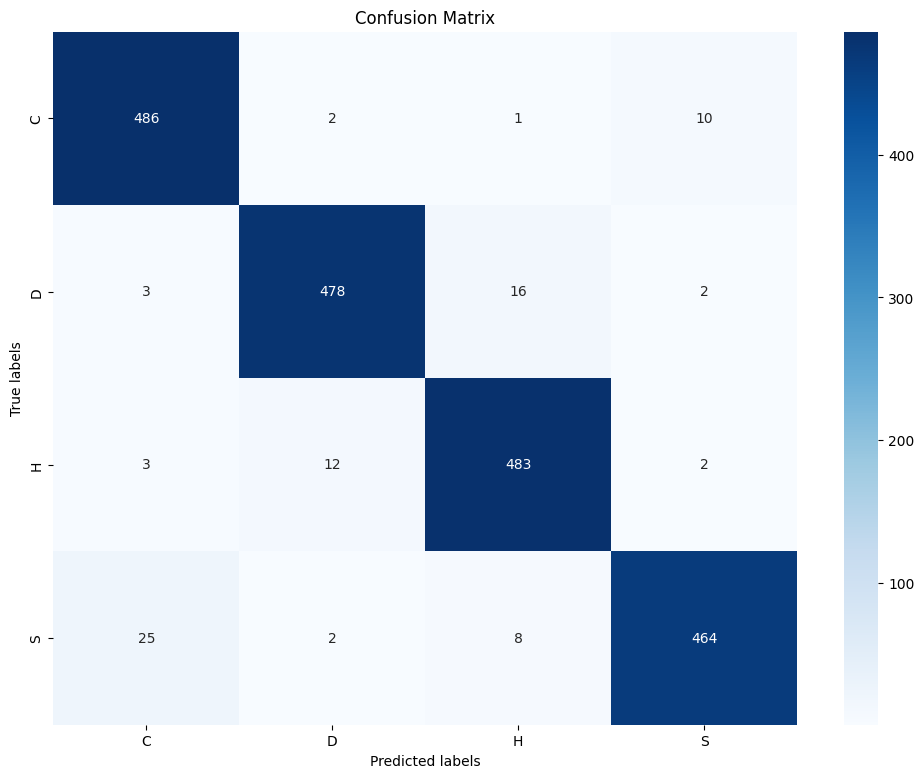

In [17]:
from sklearn.metrics import confusion_matrix
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, class_names):
    """
    Plots a confusion matrix using seaborn's heatmap.
    
    Args:
        cm (array, shape = [n, n]): Confusion matrix
        class_names (array, shape = [n]): Array of class names
    """
    plt.figure(figsize=(12, 9))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

y_test_ = np.argmax(y_test, axis=1)
y_qkeras_ = np.argmax(y_qkeras, axis=1)

cm = confusion_matrix(y_test_, y_qkeras_)

plot_confusion_matrix(cm, classes)

In [18]:
hls_model.build(
    csim=False,
    synth=True,
    cosim=False,
    export=False,
    vsynth=False,
)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /opt/xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/opt/xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'rht2122' on host 'socp06-ubuntu.c.psyched-span-141520.internal' (Linux_x86_64 version 5.4.0-1106-gcp) on Wed Apr 10 00:12:31 UTC 2024
INFO: [HLS 200-10] On os Ubuntu 18.04.6 LTS
INFO: [HLS 200-10] In directory '/home/esp2024/rht2122/PokerML/PokerML/projects/qat_hls4ml_prj_Suits'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/home/esp2024/rht2122/PokerML/PokerML/projects/qat_hls4ml_prj_Suits/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/mypr

INFO: [HLS 200-111] Finished Standard Transforms Time (s): cpu = 00:00:55 ; elapsed = 00:00:59 . Memory (MB): peak = 964.484 ; gain = 531.281 ; free physical = 14016 ; free virtual = 33983
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [XFORM 203-602] Inlining function 'nnet::Op_max<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0> >::operator()' into 'nnet::reduce<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 2, nnet::Op_max<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0> > >' (firmware/nnet_utils/nnet_common.h:43) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::reduce<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 2, nnet::Op_max<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0> > >' into 'nnet::reduce<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 4, nnet::Op_max<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0> > >' (firmware/nnet_utils/nnet_common.h:45) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::Op_max<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 

INFO: [HLS 200-489] Unrolling loop 'ReLUPackLoop' (firmware/nnet_utils/nnet_activation_stream.h:49) in function 'nnet::relu<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 4u>, nnet::array<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, 4u>, relu_config8>' completely with a factor of 4.
INFO: [HLS 200-489] Unrolling loop 'ReLUPackLoop' (firmware/nnet_utils/nnet_activation_stream.h:49) in function 'nnet::relu<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 4u>, nnet::array<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, 4u>, relu_config4>' completely with a factor of 4.
INFO: [HLS 200-489] Unrolling loop 'UpdateBuffer' (firmware/nnet_utils/nnet_conv_stream.h:233) in function 'nnet::pooling2d_cl<nnet::array<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, 4u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 4u>, config9>' completely with a factor of 4.
INFO: [HLS 200-489] Unrolling loop 'LineBufferDataIn' (firmware/nnet_utils/nnet_conv_stream.h:241) in 

INFO: [HLS 200-489] Unrolling loop 'LineBufferShift' (firmware/nnet_utils/nnet_conv_stream.h:244) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>, config2>' completely with a factor of 2.
INFO: [HLS 200-489] Unrolling loop 'KernelShiftWidth' (firmware/nnet_utils/nnet_conv_stream.h:194) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>, config2>' completely with a factor of 2.
INFO: [HLS 200-489] Unrolling loop 'KernelShiftHeight' (firmware/nnet_utils/nnet_conv_stream.h:197) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>, config2>' completely with a factor of 3.
INFO: [HLS 200-489] Unrolling loop 'KernelShiftChannel' (firmware/nnet_utils/nnet_conv_stream.h:199) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>, config2>' completely with a factor of 3.
INFO: [HLS 200-489] Unrolling 

INFO: [XFORM 203-602] Inlining function 'nnet::Op_max<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0> >::operator()' into 'nnet::reduce<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 2, nnet::Op_max<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0> > >' (firmware/nnet_utils/nnet_common.h:43) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::reduce<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 2, nnet::Op_max<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0> > >' into 'nnet::reduce<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 4, nnet::Op_max<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0> > >' (firmware/nnet_utils/nnet_common.h:45) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::Op_max<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0> >::operator()' into 'nnet::reduce<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 4, nnet::Op_max<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0> > >' (firmware/nnet_utils/nnet_common.h:45) automatically.
INFO: [XFORM 203-602] Inlining 

INFO: [XFORM 203-11] Balancing expressions in function 'nnet::compute_output_buffer_2d<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 4u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 4u>, config6>' (firmware/nnet_utils/nnet_conv_stream.h:286:5)...3 expression(s) balanced.
INFO: [XFORM 203-11] Balancing expressions in function 'nnet::compute_output_buffer_2d<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 3u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 4u>, config2>' (firmware/nnet_utils/nnet_conv_stream.h:286:5)...3 expression(s) balanced.
INFO: [HLS 200-111] Finished Pre-synthesis Time (s): cpu = 00:01:55 ; elapsed = 00:01:59 . Memory (MB): peak = 1028.809 ; gain = 595.605 ; free physical = 13875 ; free virtual = 33853
INFO: [XFORM 203-541] Flattening a loop nest 'ReadInputHeight' (firmware/nnet_utils/nnet_pooling_stream.h:241:66) in function 'nnet::pooling2d_cl<nnet::array<ap_ufixed<6, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, 4u>, n

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'Loop_1_proc290' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 166.88 seconds; current allocated memory: 516.757 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.28 seconds; current allocated memory: 517.289 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_3u_config2_s' 
INFO: [HLS 200-10] -------------------------------------

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.38 seconds; current allocated memory: 522.842 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_4u_config6_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'shift_line_buffer<array<ap_fixed<16, 6, 5, 3, 0>, 4u>, config6>'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 1.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.46 seconds; current allocated memory: 523.169 MB.
INFO: [BIND 2

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.44 seconds; current allocated memory: 528.570 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_wrapper_ap_fixed_16_6_5_3_0_ap_fixed_16_6_5_3_0_config11_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining loop 'ReuseLoop'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 45.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 29.25 seconds; current allocated memory: 540.965 MB.
INFO: [BIND 205-100] Starting micro-architecture generation .

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_resource_ap_fixed_16_6_5_3_0_ap_fixed_16_6_5_3_0_config2_mult_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mul_mul_6s_16s_21_3_1': 1 instance(s).
INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mux_42_32_1_1': 1 instance(s).
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_resource_ap_fixed_16_6_5_3_0_ap_fixed_16_6_5_3_0_config2_mult_s'.
INFO: [HLS 200-111]  Elapsed time: 0.23 seconds; current allocated memory: 659.355 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_4u_config2_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-1

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_resource_ap_fixed_16_6_5_3_0_ap_fixed_16_6_5_3_0_config6_mult_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mul_mul_6s_16s_21_3_1': 1 instance(s).
INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mux_42_32_1_1': 1 instance(s).
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_resource_ap_fixed_16_6_5_3_0_ap_fixed_16_6_5_3_0_config6_mult_s'.
INFO: [HLS 200-111]  Elapsed time: 0.37 seconds; current allocated memory: 678.900 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_4u_config6_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-1

INFO: [RTGEN 206-104] Estimated max fanout for 'dense_wrapper_ap_fixed_16_6_5_3_0_ap_fixed_16_6_5_3_0_config11_s' is 119156 from HDL expression: (1'b0 == ap_block_pp0_stage0_11001)
INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mul_mul_6s_16s_22_3_1': 8 instance(s).
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_wrapper_ap_fixed_16_6_5_3_0_ap_fixed_16_6_5_3_0_config11_s'.
INFO: [HLS 200-111]  Elapsed time: 8.25 seconds; current allocated memory: 799.755 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_array_ap_fixed_4u_array_ap_fixed_16_6_5_3_0_4u_config11_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_array_ap_fixed_4u_array_ap_fixed_16_6_5_3_0_4u_config11_s'.
INFO: [HLS 200-111]  Elapsed time: 29.26 seconds; current allocated memory: 907.190 MB.
INFO: [HLS 200-10] 

INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_2_V_U(fifo_w6_d841_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer8_out_V_data_3_V_U(fifo_w6_d841_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer9_out_V_data_0_V_U(fifo_w16_d196_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer9_out_V_data_1_V_U(fifo_w16_d196_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer9_out_V_data_2_V_U(fifo_w16_d196_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer9_out_V_data_3_V_U(fifo_w16_d196_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'start_for_relu_array_ap_fixed_4u_array_ap_ufixed_6_0_4_0_0_4u_relu_config4_U0_U(start_for_relu_array_ap_fixed_4u_array_ap_ufixed_6_0_4_0_0_4u_relu_config4_U0)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'start_for_pooling2d_cl_array_ap_ufixed_4u_array_ap_fixed_16_6_5_3_0_4u_configyd2_U(start_for_pooling2d_cl_array_ap_ufixed_4u_array_ap_fixed

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '6.279',
  'BestLatency': '487768',
  'WorstLatency': '487769',
  'IntervalMin': '118786',
  'IntervalMax': '487426',
  'BRAM_18K': '56',
  'DSP': '11',
  'FF': '98733',
  'LUT': '90525',
  'URAM': '0',
  'AvailableBRAM_18K': '280',
  'AvailableDSP': '220',
  'AvailableFF': '106400',
  'AvailableLUT': '53200',
  'AvailableURAM': '0'}}

In [ ]:
hls4ml.report.read_vivado_report('projects/qat_hls4ml_prj')